In [ ]:
import pandas as pd

def load_data(path, sample_size=None, random_state=42):
    
    #Optimizing for 14M rows
    dtype_dict = {f"f{i}": "float32" for i in range(12)}
    dtype_dict["treatment"] = "int8"
    dtype_dict["conversion"] = "int8"
    dtype_dict["visit"] = "int8"
    dtype_dict["exposure"] = "int8"

    df = pd.read_csv(path, dtype=dtype_dict)

    if sample_size:
        df = df.sample(n=sample_size, random_state=random_state)

    return df

In [3]:
df = load_data("D:\\Switch\\Projects\\Uplift Modeling\\Data\\criteo-uplift-v2.1.csv")   # full 14M

In [4]:
df = df.drop(columns=["visit", "exposure"])

In [5]:
df.info(memory_usage="deep")

<class 'pandas.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 14 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float32
 1   f1          float32
 2   f2          float32
 3   f3          float32
 4   f4          float32
 5   f5          float32
 6   f6          float32
 7   f7          float32
 8   f8          float32
 9   f9          float32
 10  f10         float32
 11  f11         float32
 12  treatment   int8   
 13  conversion  int8   
dtypes: float32(12), int8(2)
memory usage: 666.6 MB


In [14]:
#Profit Function
import numpy as np
def compute_profit(df, score_col, cost=5, profit=40):
    
    df = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    
    n = len(df)
    profits = []
    
    for frac in np.linspace(0.01, 1.0, 50):
        
        k = int(frac * n)
        targeted = df.iloc[:k]
        
        treated = targeted[targeted['treatment'] == 1]
        control = targeted[targeted['treatment'] == 0]
        
        conv_treated = treated['conversion'].sum()
        conv_control = control['conversion'].sum()
        
        # Incremental conversions
        if len(control) > 0:
            control_rate = conv_control / len(control) #-> Rate of users getting converted without promo
        else:
            control_rate = 0
        
        #control_rate*len(treated) is just expected baseline conversion
        incremental = conv_treated - control_rate * len(treated)
        
        total_profit = incremental * profit - k * cost
        
        profits.append(total_profit)
    
    return profits

In [7]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['conversion'])
y = df['conversion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=df[['treatment','conversion']]
)

In [11]:
features = [col for col in X_train.columns if col != 'treatment']
X_train_model = X_train[features]
X_test_model = X_test[features]

In [ ]:
#Splitting X train by treatment
treated_idx = X_train['treatment'] == 1
control_idx = X_train['treatment'] == 0

X_train_treated = X_train.loc[treated_idx, features]
y_train_treated = y_train.loc[treated_idx]

X_train_control = X_train.loc[control_idx, features]
y_train_control = y_train.loc[control_idx]

In [10]:
test_df = X_test.copy()
test_df['conversion'] = y_test.values

In [9]:
from xgboost import XGBClassifier
model_treated = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_control = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_treated.fit(X_train_treated, y_train_treated)
model_control.fit(X_train_control, y_train_control)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [12]:
mu1 = model_treated.predict_proba(X_test_model)[:, 1]
mu0 = model_control.predict_proba(X_test_model)[:, 1]

test_df['score_t_learner'] = mu1 - mu0

In [15]:

t_learner_profits = compute_profit(test_df, 'score_t_learner')

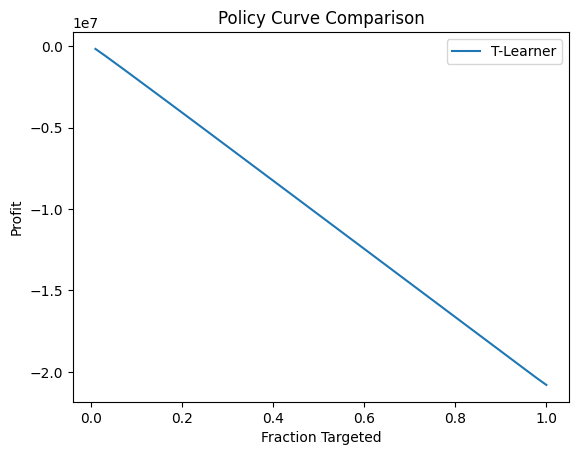

In [16]:
import matplotlib.pyplot as plt
fractions = np.linspace(0.01, 1.0, 50)
plt.figure()
plt.plot(fractions, t_learner_profits, label="T-Learner")
plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve Comparison")
plt.legend()
plt.show()

In [18]:
# Recreate test_df cleanly
test_df = X_test.copy()
test_df['conversion'] = y_test.values

# Random
np.random.seed(42)
test_df['score_random'] = np.random.rand(len(test_df))

# Conversion model

# T-Learner
mu1 = model_treated.predict_proba(X_test_model)[:, 1]
mu0 = model_control.predict_proba(X_test_model)[:, 1]
test_df['score_t_learner'] = mu1 - mu0

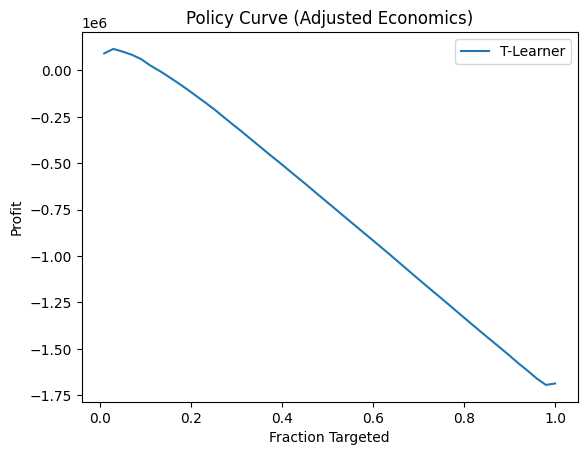

In [19]:
COST = 0.5
PROFIT = 100
t_learner_profits_new = compute_profit(test_df, 'score_t_learner', cost=COST, profit=PROFIT)
plt.figure()
plt.plot(fractions, t_learner_profits_new, label="T-Learner")

plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve (Adjusted Economics)")
plt.legend()
plt.show()

X-Learner

In [20]:
# Predict counterfactuals on training data

mu1_train = model_treated.predict_proba(X_train_model)[:, 1]
mu0_train = model_control.predict_proba(X_train_model)[:, 1]

# Initialize tau
tau = np.zeros(len(X_train))

# For treated units
tau[treated_idx] = y_train_treated.values - mu0_train[treated_idx]

# For control units
tau[control_idx] = mu1_train[control_idx] - y_train_control.values

In [21]:
from xgboost import XGBRegressor
effect_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

effect_model.fit(X_train_model, tau)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [25]:
X_train_model.shape

(9785714, 12)

In [22]:
test_df['score_x_learner'] = effect_model.predict(X_test_model)
x_learner_profits = compute_profit(test_df, 'score_x_learner', cost=COST, profit=PROFIT)

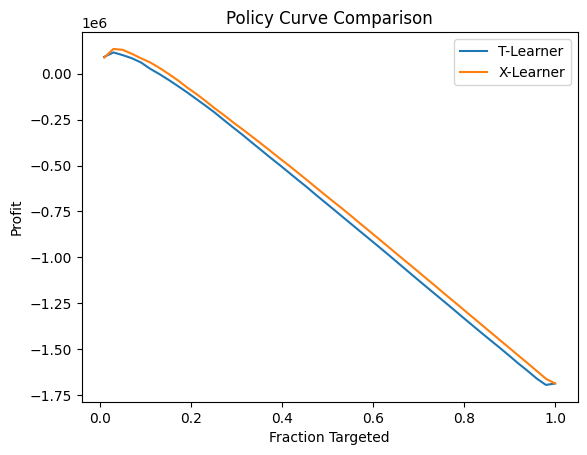

In [23]:
plt.figure()
plt.plot(fractions, t_learner_profits_new, label="T-Learner")
plt.plot(fractions, x_learner_profits, label="X-Learner")

plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve Comparison")
plt.legend()
plt.show()

d:\Switch\Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Garvit Chandel\AppData\Local\Temp\ipykernel_20900\1542244798.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_model[:5000])


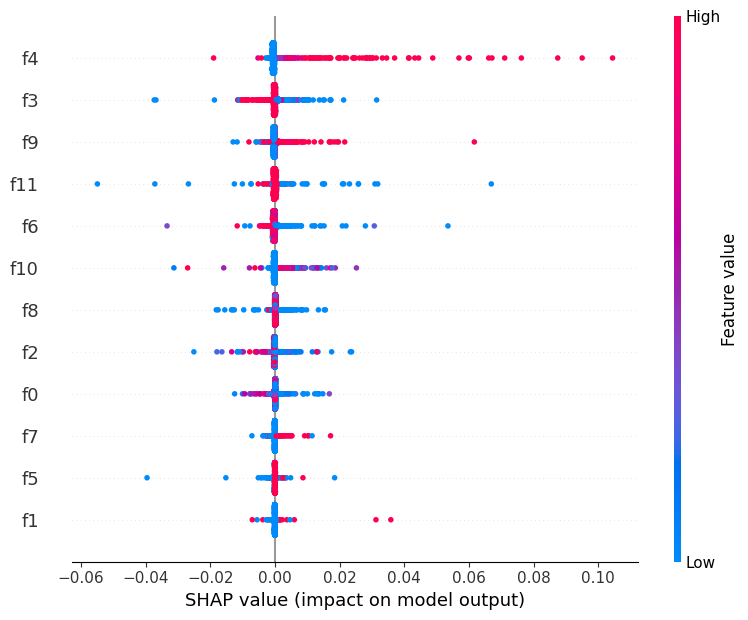

In [24]:
import shap

explainer = shap.TreeExplainer(effect_model)
shap_values = explainer.shap_values(X_test_model[:5000])

shap.summary_plot(shap_values, X_test_model[:5000])

In [27]:
x_profits = compute_profit(test_df, 'score_x_learner', COST, PROFIT)

In [29]:
#Optimal targeting fraction for X-Learner
best_idx = np.argmax(x_profits)
best_fraction = fractions[best_idx]
best_profit = x_profits[best_idx]

best_fraction, best_profit

(np.float64(0.030204081632653063), np.float64(134804.2934808757))

Final Validation Summary

Models were prototyped on a 2M stratified sample and retrained on the full 14M dataset using memory-optimized dtypes.

The optimal targeting fraction remained stable at ~3%, confirming robustness of uplift ranking.

X-Learner consistently outperformed T-Learner and conversion-based targeting in both Qini AUC and profit simulation.

Economic sensitivity analysis showed profitability across realistic promotion cost and conversion value ranges.

Conclusion:
Uplift-based targeting reliably maximizes incremental profit and provides a stable, decision-ready campaign policy at scale.